In [40]:
""" IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL """

' IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL '

In [48]:
import os
import sys
import cv2
import numpy as np
from matplotlib.pyplot import figure, imshow, plot, subplot
import pytorchvideo
import pytorch_lightning
import pytorchvideo.models.resnet
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor, save
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from pytorch_lightning.callbacks import RichProgressBar
import pywt

modules_path = 'C:/Users/PMLS/FYP/Modules/'
dataset_path = 'C:/Users/PMLS/FYP/Dataset/STMM'
save_path = "C:/Users/PMLS/FYP/Models"

sys.path.insert(1, modules_path)
from video_dataset import VideoFrameDataset, ImglistToTensor

if False and torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


In [50]:
# Load dataset
img_w = 640
img_h = 480
frames_per_video = 7
batch_size = 1

dataset = VideoFrameDataset(
    root_path= f"{dataset_path}",
    annotationfile_path=f"{dataset_path}/annotations.txt",
    num_segments=8,
    frames_per_segment=1,
    imagefile_template='{:01d}.jpg',
    transform=ImglistToTensor(),
    test_mode=False
)
class_map = {0:"down", 1:"left", 2:"right", 3:"up"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.2,0.2,0.6])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [76]:
def wavelet_transform(batch):
    batch2=[]
    for frame in batch:
        A, B = pywt.dwt(frame, 'db1')
        batch2.append(A)
    return np.array(batch2)

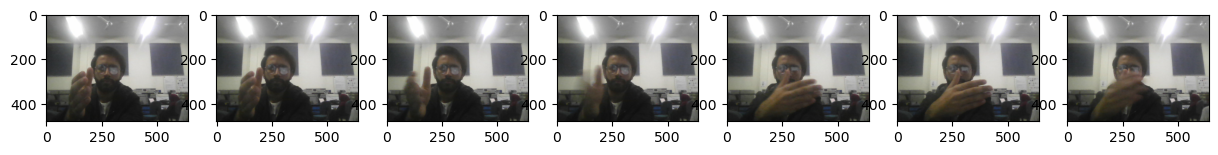

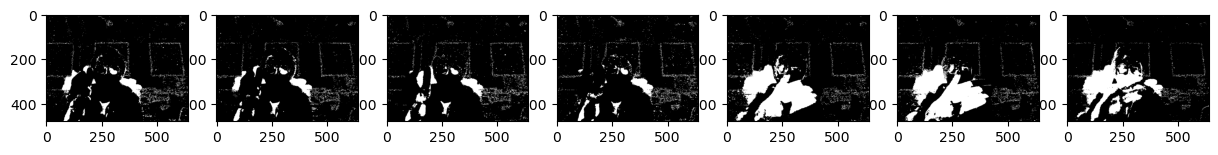

In [54]:
# Manual testing
    
def grey_transform(self, batch):
        batch = np.array(batch).transpose(0,1,3,4,2)
        favg = np.average(batch[0], axis=0)
        grey_avg = cv2.cvtColor(favg, cv2.COLOR_BGR2GRAY)
        batch2 = []
        for frame in batch[0]:
            frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame2 = frame2 - grey_avg
            threshhold = np.max(frame2) * 0.05
            _, frame2 = cv2.threshold(frame2, threshhold, 255, cv2.THRESH_BINARY)
            batch2.append([frame2])
        return np.array([batch2])
    
def videoplot(x, t=False):
    if t:
        figure(1,figsize=(15,5))
        for i in range(7):
            subplot(1,7,i+1)
            imshow(x[i].transpose(0,2).transpose(0,1))
    else:
        figure(2,figsize=(15,5))
        for i in range(7):
            subplot(1,7,i+1)
            imshow(x[i][0], cmap='gray')

for t, (x,y) in enumerate(valid_loader):
    videoplot(x[0],True)
    x = grey_transform(None, x)
    videoplot(x[0])
    break

In [78]:
avg_features=[0,0,0,0]
n_avg_features=[0,0,0,0]

for t, (x,y) in enumerate(valid_loader):
    #x = grey_transform(None, x)
    x = wavelet_transform(np.array(x))
    
    if n_avg_features[y]==0:
        avg_features[y] = x
    else:
        avg_features[y] += x
    n_avg_features[y] += 1
    if not t%10: print(t)
    if t>100: break

for i in range(4):
    avg_features[i] = avg_features[i]/n_avg_features[i]
a=avg_features

0
10
20
30
40
50
60
70
80
90
100


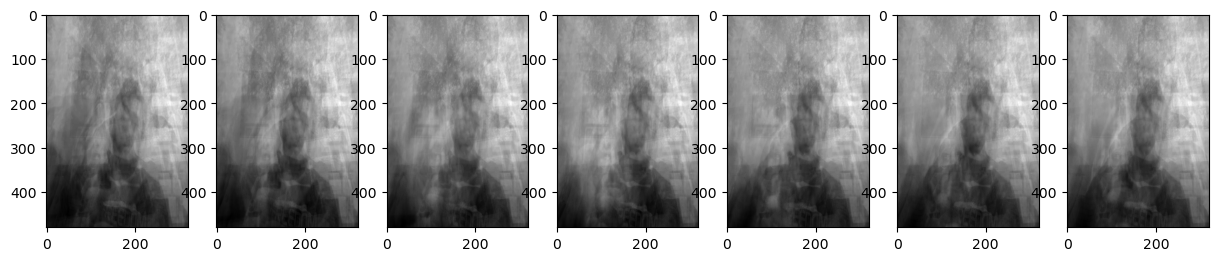

In [79]:
videoplot(a[0][0])

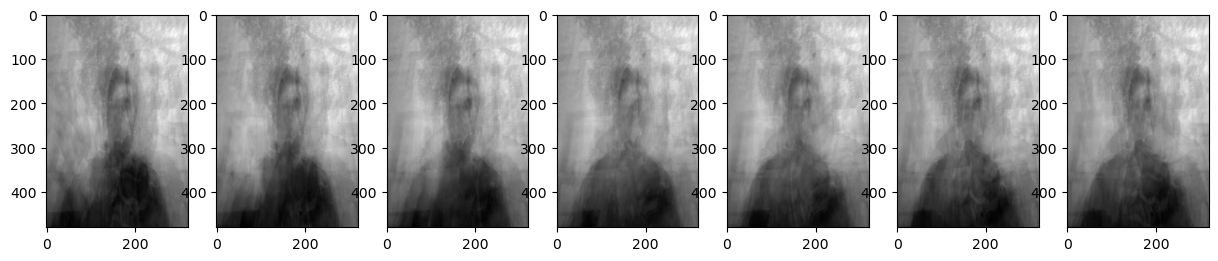

In [82]:
videoplot(a[1][0])

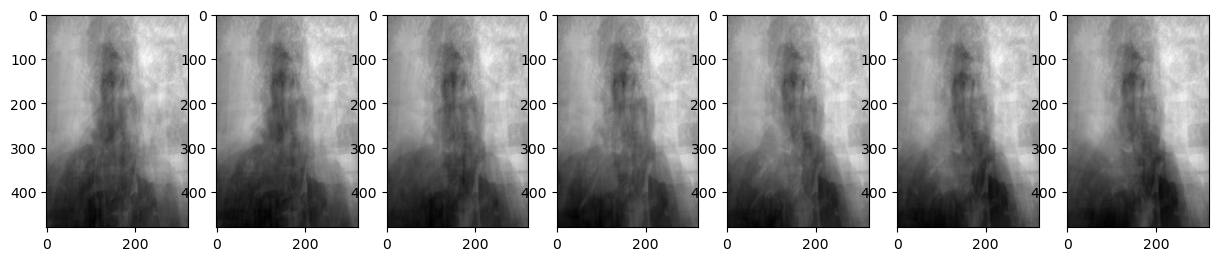

In [84]:
videoplot(a[2][0])

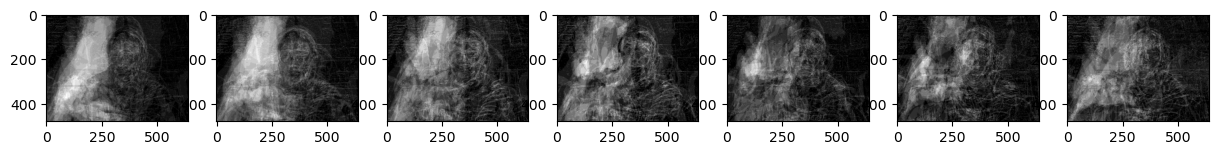

In [60]:
videoplot(a[3][0])

(<Figure size 500x500 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x1d62ba9ee70>])

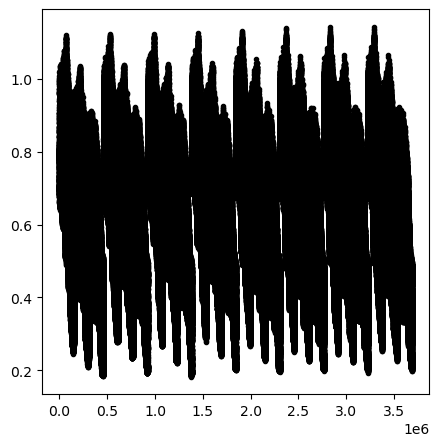

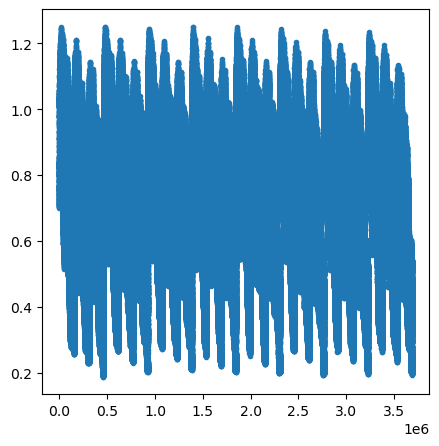

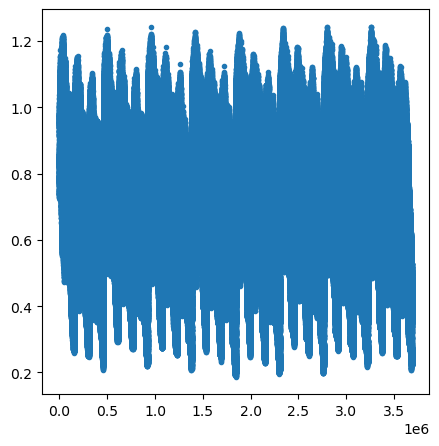

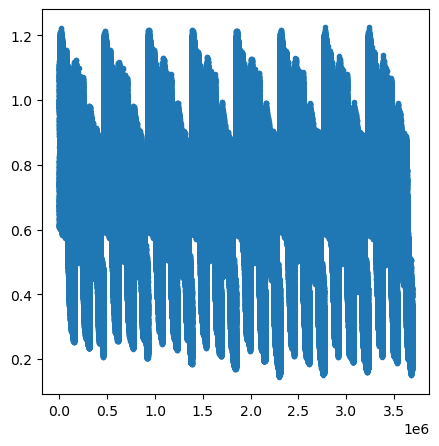

In [86]:
s0=a[0].flatten()
s1=a[1].flatten()
s2=a[2].flatten()
s3=a[3].flatten()
figure(1, figsize=(5,5)), plot(s0,'k.')
figure(2, figsize=(5,5)), plot(s1,'.')
figure(3, figsize=(5,5)), plot(s2,'.')
figure(4, figsize=(5,5)), plot(s3,'.')